In [1]:
#Check what features correlate with the target variable

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr, spearmanr


%config InlineBackend.figure_format = 'png' #set 'png' here when working on notebook
%matplotlib inline

In [2]:
train = pd.read_csv(r"C:\Users\piush\Desktop\Dataset\House_Prices\train.csv")
test = pd.read_csv(r"C:\Users\piush\Desktop\Dataset\House_Prices\train.csv")

In [3]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

### Data preprocessing

In [4]:
#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

all_data = pd.get_dummies(all_data)

#filling NA's with the median of the column:
all_data = all_data.fillna(all_data.median())

#creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

### Check the correlations
Since a lot of features are skewed we calculate spearman correlation instead of the default pearson correlation.

In [5]:
all_corr = X_train[X_train.columns[1:-1]].apply(lambda x: pd.Series(spearmanr(x,y))).T

In [8]:
all_corr.columns = ['Correlation', 'pvalue']

In [9]:
# Sort the table according the absolute value of the correlations
all_corr=all_corr.reindex(all_corr.Correlation.abs().sort_values(ascending=False).index)

In [10]:
# Determine what features are significant (p value < 0.05)
bins=[-0.0001, 0.001, 0.01, 0.05,1]
all_corr['Significance'] = pd.cut(all_corr.pvalue, bins, labels=['***','**','*','.'])

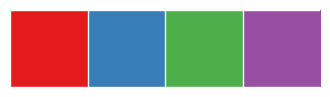

In [12]:
# http://colorbrewer2.org/?type=qualitative&scheme=Set1&n=4
colors = ['#e41a1c','#377eb8','#4daf4a','#984ea3']
sns.palplot(sns.color_palette(colors))

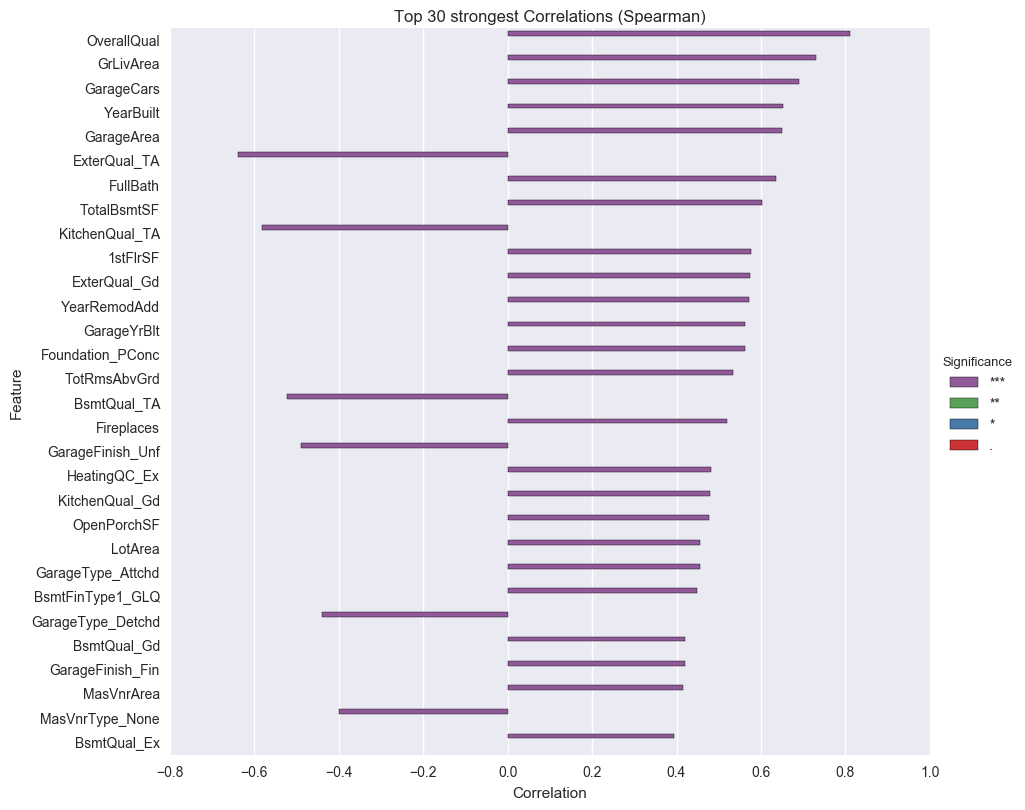

In [13]:
g = sns.factorplot(y='Feature', x='Correlation', hue='Significance',
                   data=all_corr.reset_index().rename(columns={'index':'Feature'})[:30], 
                   kind='bar', orient='h', size=8, aspect=1.2,
                   palette={"***":"#984ea3", "**": "#4daf4a", "*": "#377eb8", ".":"#e41a1c"})
g.ax.set_title('Top 30 strongest Correlations (Spearman)');

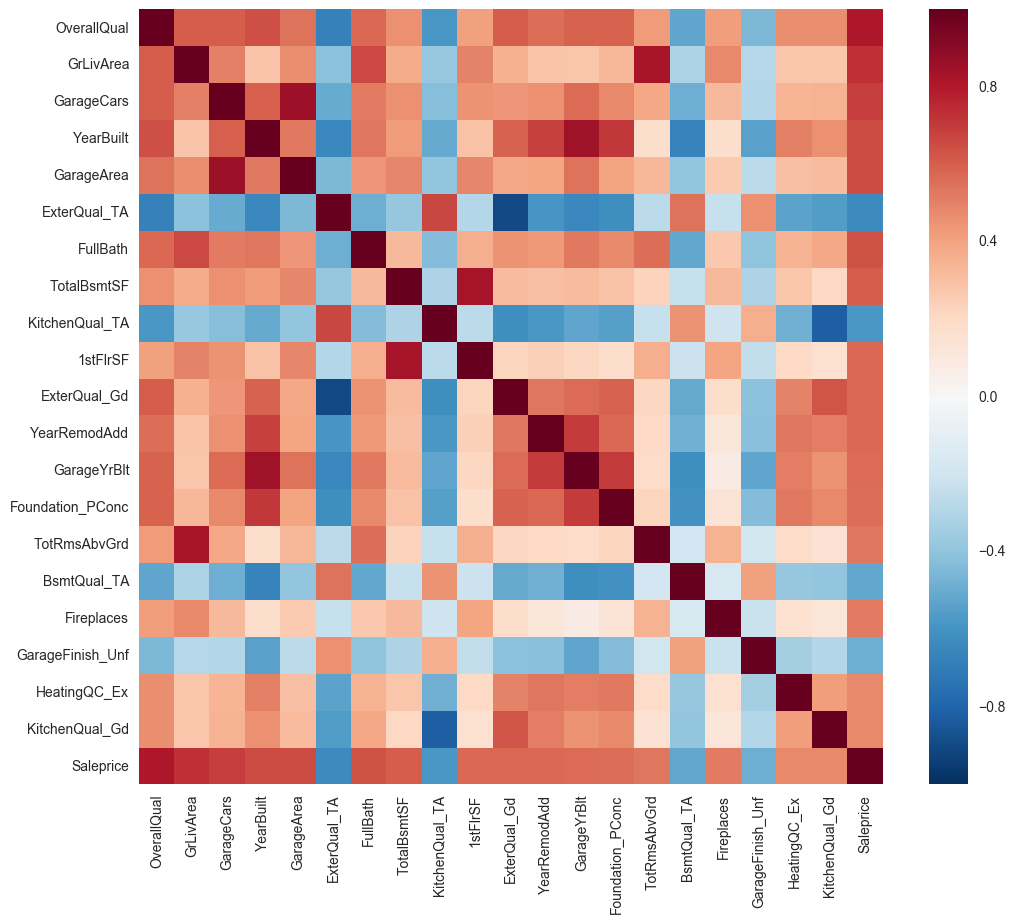

In [14]:
# Correlation between features that correlate with SalePrice (spearman bigger then 0.4)
corrs = X_train[all_corr.index[:20].values].copy()
corrs['Saleprice'] = y
cor_mat = corrs.corr(method='spearman')
f, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(cor_mat,ax=ax);

In [15]:
# only important correlations and not auto-correlations
threshold = 0.6
important_corrs = (cor_mat[abs(cor_mat) > threshold][cor_mat != 1.0]) \
    .unstack().dropna().to_dict()
unique_important_corrs = pd.DataFrame(
    list(set([(tuple(sorted(key)), important_corrs[key]) \
    for key in important_corrs])), columns=['attribute pair', 'correlation'])
# sorted by absolute value
unique_important_corrs = unique_important_corrs.ix[
    abs(unique_important_corrs['correlation']).argsort()[::-1]]
unique_important_corrs

,attribute pair,correlation
10,"(ExterQual_Gd, ExterQual_TA)",-0.906121
29,"(GarageArea, GarageCars)",0.853317
17,"(GarageYrBlt, YearBuilt)",0.845595
23,"(1stFlrSF, TotalBsmtSF)",0.829292
27,"(GrLivArea, TotRmsAbvGrd)",0.827874
20,"(KitchenQual_Gd, KitchenQual_TA)",-0.824457
15,"(OverallQual, Saleprice)",0.809829
14,"(GrLivArea, Saleprice)",0.731310
21,"(Foundation_PConc, YearBuilt)",0.704001
5,"(Foundation_PConc, GarageYrBlt)",0.700041


#### Clusters

In [16]:
# Recipe from https://github.com/mgalardini/python_plotting_snippets/blob/master/notebooks/clusters.ipynb
import matplotlib.patches as patches
from scipy.cluster import hierarchy
from scipy.stats.mstats import mquantiles
from scipy.cluster.hierarchy import dendrogram, linkage

In [17]:
# Correlate the data
# also precompute the linkage
# so we can pick up the 
# hierarchical thresholds beforehand

from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler

# scale to mean 0, variance 1
train_std = pd.DataFrame(scale(corrs))
train_std.columns = corrs.columns
m = train_std.corr(method='spearman')
l = linkage(m, 'ward')

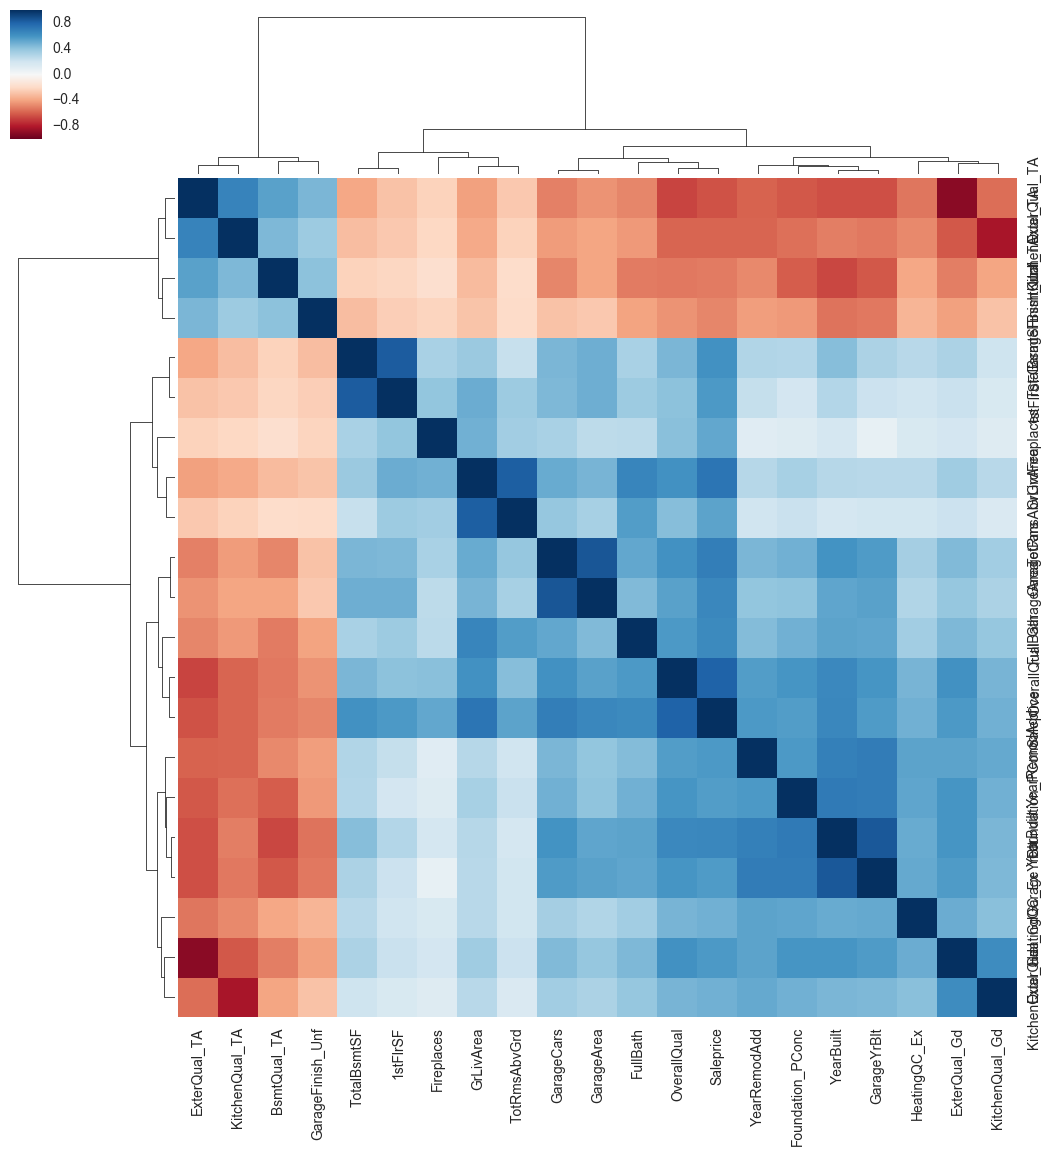

In [18]:
# Plot the clustermap
# Save the returned object for further plotting
mclust = sns.clustermap(m,
               linewidths=0,
               cmap=plt.get_cmap('RdBu'),
               vmax=1,
               vmin=-1,
               figsize=(13, 13),
               row_linkage=l,
               col_linkage=l)

In [19]:
# Threshold 1: median of the
# distance thresholds computed by scipy
t = np.median(hierarchy.maxdists(l))

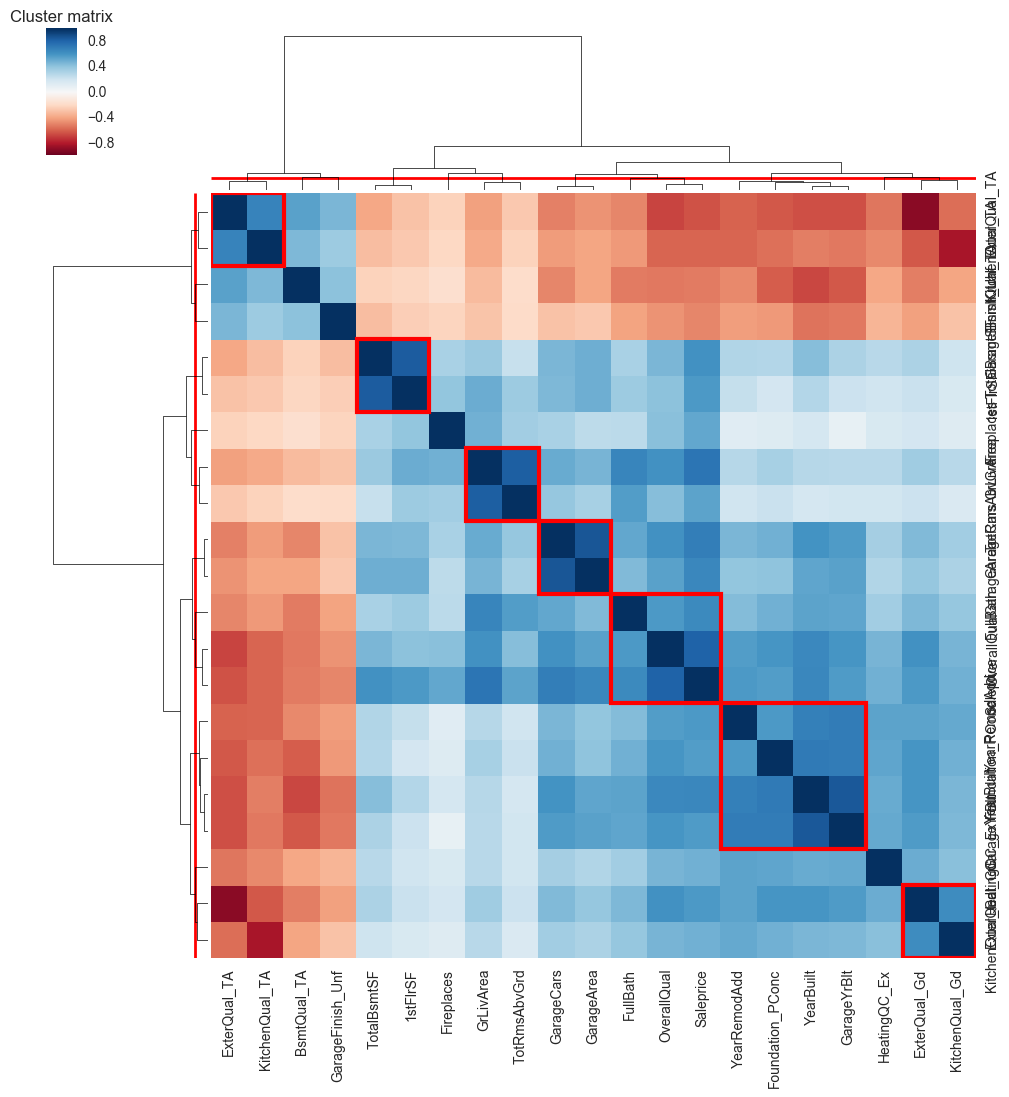

In [22]:
# Plot the clustermap
# Save the returned object for further plotting
mclust = sns.clustermap(m,
               linewidths=0,
               cmap=plt.get_cmap('RdBu'),
               vmax=1,
               vmin=-1,
               figsize=(12, 12),
               row_linkage=l,
               col_linkage=l)
# Draw the threshold lines
mclust.ax_col_dendrogram.hlines(t,
                               0,
                               m.shape[0]*10,
                               colors='r',
                               linewidths=2,
                               zorder=1)
mclust.ax_row_dendrogram.vlines(t,
                               0,
                               m.shape[0]*10,
                               colors='r',
                               linewidths=2,
                               zorder=1)
# Extract the clusters
clusters = hierarchy.fcluster(l, t, 'distance')
for c in set(clusters):
    # Retrieve the position in the clustered matrix
    index = [x for x in range(m.shape[0])
             if mclust.data2d.columns[x] in m.index[clusters == c]]
    # No singletons, please
    if len(index) == 1:
        continue

    # Draw a rectangle around the cluster
    mclust.ax_heatmap.add_patch(
        patches.Rectangle(
            (min(index),
             m.shape[0] - max(index) - 1),
                len(index),
                len(index),
                facecolor='none',
                edgecolor='r',
                lw=3)
        )

plt.title('Cluster matrix')

pass

In [23]:
# Threshold 2: higher quartile of the same distribution
t = mquantiles(hierarchy.maxdists(l), prob=0.75)[0]

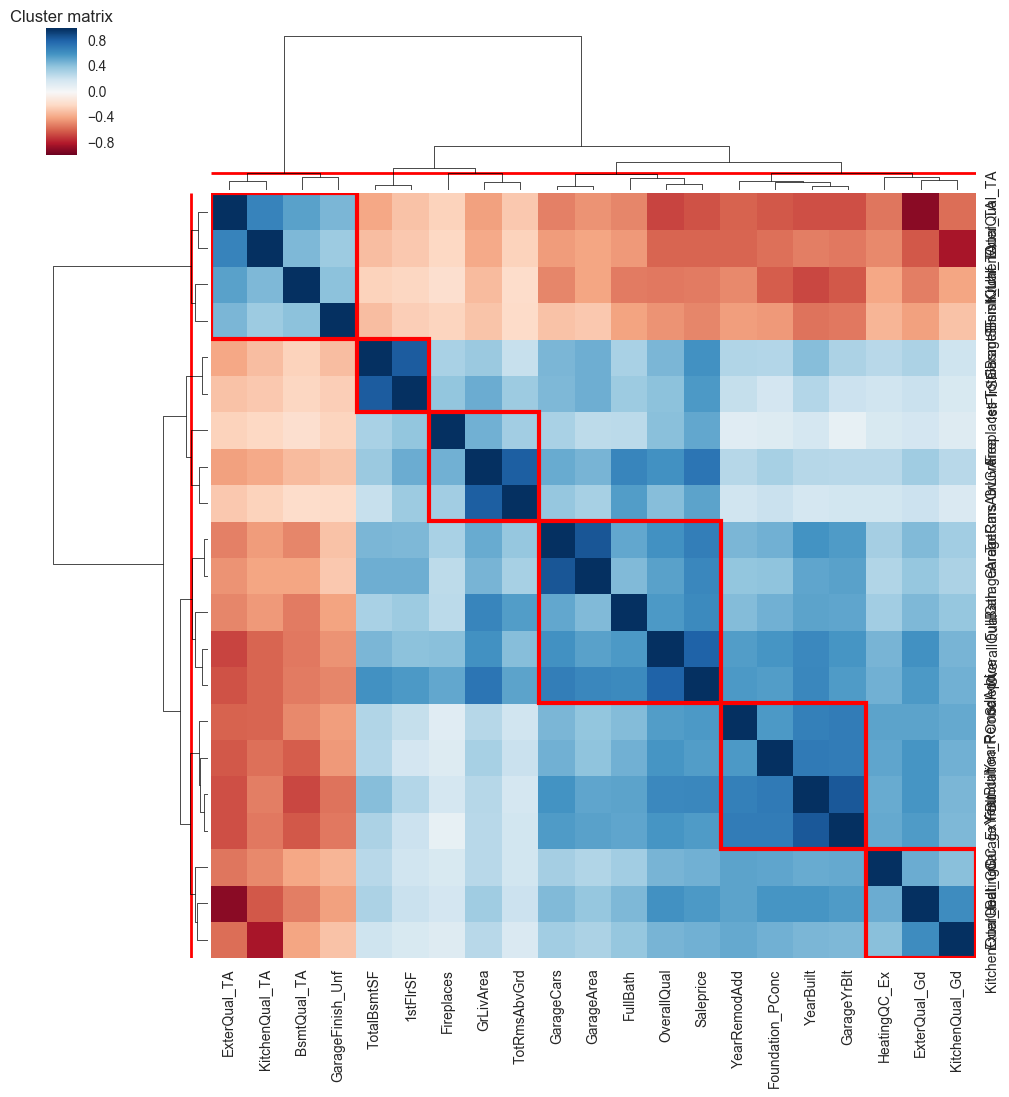

In [24]:
# Plot the clustermap
# Save the returned object for further plotting
mclust = sns.clustermap(m,
               linewidths=0,
               cmap=plt.get_cmap('RdBu'),
               vmax=1,
               vmin=-1,
               figsize=(12, 12),
               row_linkage=l,
               col_linkage=l)

# Draw the threshold lines
mclust.ax_col_dendrogram.hlines(t,
                               0,
                               m.shape[0]*10,
                               colors='r',
                               linewidths=2,
                               zorder=1)
mclust.ax_row_dendrogram.vlines(t,
                               0,
                               m.shape[0]*10,
                               colors='r',
                               linewidths=2,
                               zorder=1)

# Extract the clusters
clusters = hierarchy.fcluster(l, t, 'distance')
for c in set(clusters):
    # Retrieve the position in the clustered matrix
    index = [x for x in range(m.shape[0])
             if mclust.data2d.columns[x] in m.index[clusters == c]]
    # No singletons, please
    if len(index) == 1:
        continue

    # Draw a rectangle around the cluster
    mclust.ax_heatmap.add_patch(
        patches.Rectangle(
            (min(index),
             m.shape[0] - max(index) - 1),
                len(index),
                len(index),
                facecolor='none',
                edgecolor='r',
                lw=3)
        )

plt.title('Cluster matrix')
#plt.yticks(rotation=0)

pass

In [25]:
# This are the clusters
for c in set(clusters):
    # Retrieve the position in the clustered matrix
    index = [x for x in range(m.shape[0])
             if mclust.data2d.columns[x] in m.index[clusters == c]]
    # No singletons, please
    if len(index) == 1:
        continue
    print(m.iloc[index].index.values)

['OverallQual' 'GrLivArea' 'GarageCars' 'YearBuilt']
['GarageArea' 'ExterQual_TA']
['FullBath' 'TotalBsmtSF' 'KitchenQual_TA']
['1stFlrSF' 'ExterQual_Gd' 'YearRemodAdd' 'GarageYrBlt' 'Foundation_PConc']
['TotRmsAbvGrd' 'BsmtQual_TA' 'Fireplaces' 'GarageFinish_Unf']
['HeatingQC_Ex' 'KitchenQual_Gd' 'Saleprice']


### Multicolinearity
Based on Vishal Patel | A Practical Guide to Dimensionality Reduction

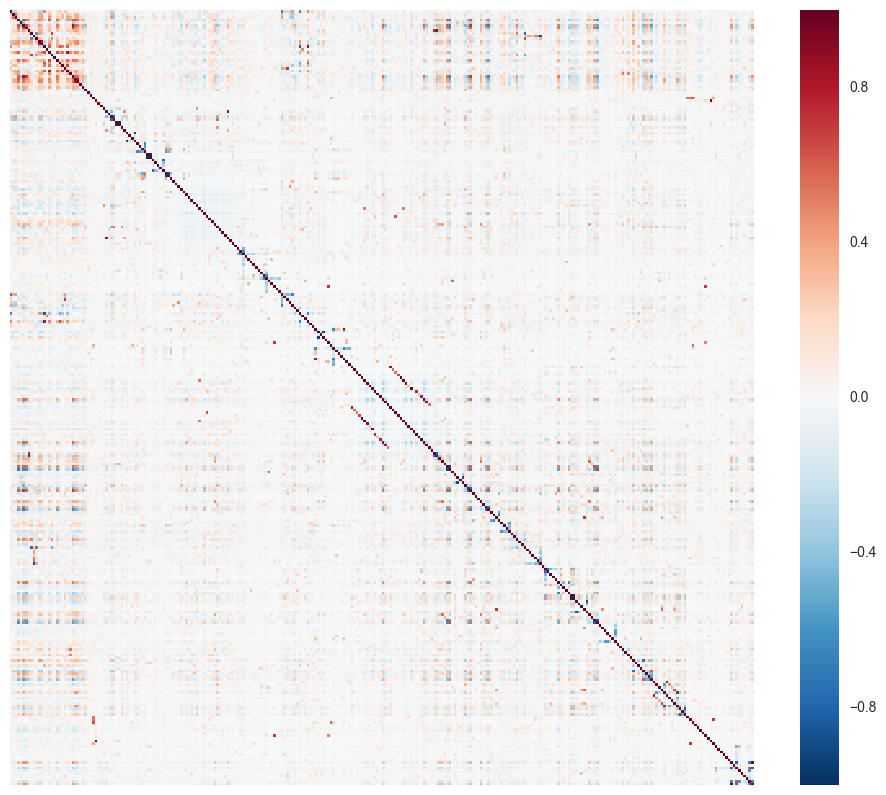

In [26]:
corrMatrix = X_train.corr(method='spearman')
f, ax = plt.subplots(figsize=(12, 10))
empty_labels = ['']*corrMatrix.shape[0]
sns.heatmap(corrMatrix, xticklabels=empty_labels, yticklabels=empty_labels, ax=ax);

In [27]:
# Remove multicolineair features
minVarsKeep = 40
for dims in range(corrMatrix.shape[0], minVarsKeep, -1):
    w,v = np.linalg.eig(corrMatrix)
    w1 = (np.max(w)/w)**0.5
    if np.max(w1) < 10.0:
        print ('Condition index is less then 10.0')
        break
    feature_to_remove = corrMatrix.columns[v[:,w.argmin()].argmax()]
    print ('Feature to remove: {}'.format(feature_to_remove))
    corrMatrix.drop(feature_to_remove, inplace=True)
    corrMatrix.drop(feature_to_remove, axis=1, inplace=True)

Feature to remove: MSZoning_RL
Feature to remove: Condition1_Norm
Feature to remove: LotConfig_Inside
Feature to remove: SaleType_WD
Feature to remove: Foundation_PConc
Feature to remove: LandContour_Lvl
Feature to remove: RoofMatl_CompShg
Feature to remove: ExterQual_TA
Feature to remove: LandSlope_Gtl
Feature to remove: Heating_GasA
Feature to remove: GarageQual_TA
Feature to remove: Exterior2nd_VinylSd
Feature to remove: Functional_Typ
Feature to remove: Exterior1st_CBlock
Feature to remove: HouseStyle_1Story
Feature to remove: LotShape_Reg
Feature to remove: GarageType_Attchd
Feature to remove: HeatingQC_Ex
Feature to remove: Condition2_Norm
Feature to remove: BsmtQual_TA
Feature to remove: Street_Grvl
Feature to remove: GarageFinish_Unf
Feature to remove: KitchenQual_TA
Feature to remove: BldgType_1Fam
Feature to remove: BsmtCond_TA
Feature to remove: PavedDrive_Y
Feature to remove: Utilities_AllPub
Feature to remove: CentralAir_Y
Feature to remove: Neighborhood_NAmes
Feature to r

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: RuntimeWarning: invalid value encountered in sqrt


Feature to remove: Exterior1st_VinylSd
Feature to remove: BsmtFinType2_Unf
Feature to remove: ExterCond_TA
Feature to remove: BsmtFinType1_Unf
Feature to remove: RoofStyle_Gable
Feature to remove: Electrical_SBrkr
Feature to remove: BsmtFinType2_Rec
Feature to remove: Exterior2nd_MetalSd
Feature to remove: MasVnrType_BrkFace
Feature to remove: BsmtUnfSF
Feature to remove: MiscVal
Feature to remove: SaleCondition_Partial
Feature to remove: BsmtExposure_No
Feature to remove: Exterior1st_CemntBd
Feature to remove: Exterior1st_HdBoard
Feature to remove: FireplaceQu_Gd
Feature to remove: 2ndFlrSF
Feature to remove: HouseStyle_2Story
Feature to remove: BldgType_TwnhsE
Feature to remove: YearBuilt
Feature to remove: MasVnrArea
Feature to remove: Exterior1st_Wd Sdng
Feature to remove: BsmtFinSF1
Feature to remove: GrLivArea
Feature to remove: RoofStyle_Flat
Feature to remove: MSZoning_FV
Feature to remove: Neighborhood_CollgCr
Feature to remove: Neighborhood_OldTown
Feature to remove: TotalBsm

In [28]:
corrMatrix.info

<bound method DataFrame.info of                        MSSubClass  LotFrontage   LotArea  OverallQual  \
MSSubClass               1.000000    -0.280102 -0.269570     0.108065   
LotFrontage             -0.280102     1.000000  0.554082     0.230305   
LotArea                 -0.269570     0.554082  1.000000     0.233303   
OverallQual              0.108065     0.230305  0.233303     1.000000   
OverallCond             -0.071770    -0.072772 -0.046912    -0.177521   
YearRemodAdd             0.006802     0.101659  0.075158     0.557723   
BsmtFinSF2              -0.083871     0.052350  0.072019    -0.117560   
1stFlrSF                -0.278318     0.384900  0.443858     0.408730   
LowQualFinSF             0.075794    -0.034600 -0.020255    -0.034029   
BsmtFullBath            -0.042017     0.078139  0.095609     0.098034   
BsmtHalfBath             0.002480     0.000334  0.045970    -0.050598   
FullBath                 0.194912     0.193805  0.235377     0.576372   
HalfBath           

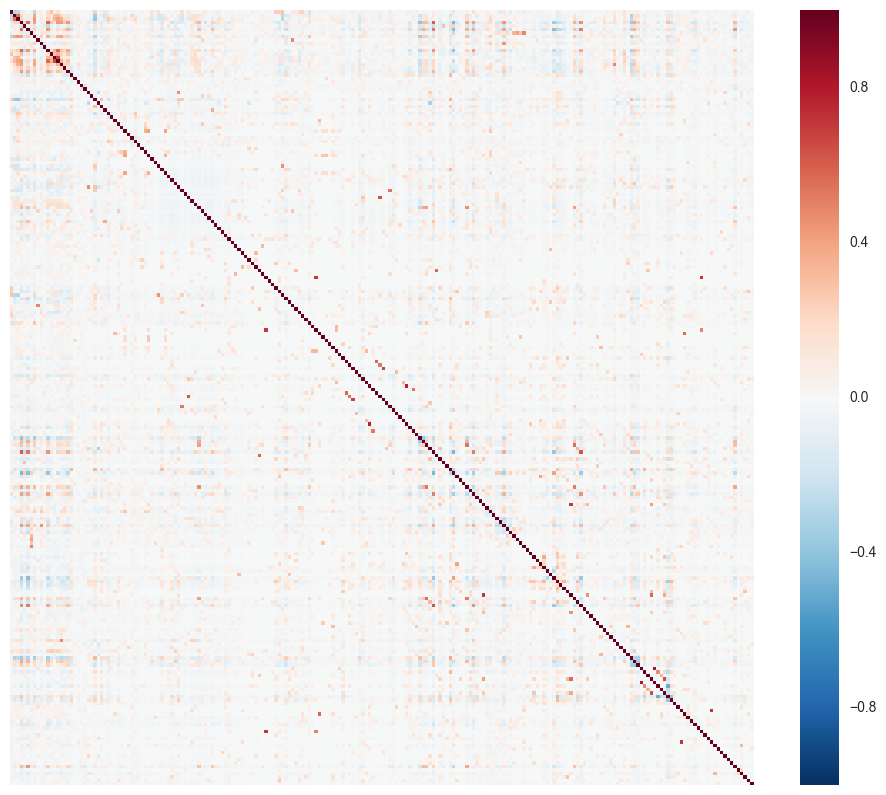

In [29]:
f, ax = plt.subplots(figsize=(12, 10))
empty_labels = ['']*corrMatrix.shape[0]
sns.heatmap(corrMatrix, xticklabels=empty_labels, yticklabels=empty_labels, ax=ax);